<center>
<img src="../logo.png" height="900"> 
</center>


#  Кластеризация временных рядов

__Тут выражается благодарность [Сергееву Дмитрию](https://github.com/DmitrySerg) за помощь в создании материалов.__ 

В этой тетрадке мы займёмся кластеризацией временных рядов.


In [22]:
import numpy as np
import pandas as pd

from scipy import stats 

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import seaborn as sns

%matplotlib inline

# 1. Данные 

В этой тетрадке мы займёмся кластеризацией финансовых данных. Чтобы подгрузить данные о стоимости акций, воспользуемся сервисов yahoo finance, предоставляющим удобное API для выгрузки данных. 

In [23]:
import yfinance as yf

goog = yf.Ticker("GOOG")
goog.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-29,1522.359985,1593.709961,1522.239990,1567.239990,2003100,0,0
2020-10-30,1672.109985,1687.000000,1604.459961,1621.010010,4329100,0,0
2020-11-02,1628.160034,1660.770020,1616.030029,1626.030029,2535400,0,0
2020-11-03,1631.780029,1661.699951,1616.619995,1650.209961,1661700,0,0
2020-11-04,1710.280029,1771.364990,1706.030029,1749.130005,3570900,0,0
2020-11-05,1781.000000,1793.640015,1750.510010,1763.369995,2065800,0,0
2020-11-06,1753.949951,1772.430054,1740.349976,1761.750000,1660900,0,0
2020-11-09,1790.900024,1818.060059,1760.020020,1763.000000,2268300,0,0
2020-11-10,1731.089966,1763.000000,1717.300049,1740.390015,2636100,0,0


In [24]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [25]:
get_info(goog)

{'shortName': 'Alphabet Inc.',
 'sector': 'Communication Services',
 'industry': 'Internet Content & Information',
 'country': 'United States',
 'market': 'us_market'}

Если хочется все тикеры и сразу, можно спарсить с git удобный список: 

In [26]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv', 
    header=None,
    error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4])

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


А ещё можно попробовать достать самые интересные тикеры из текущих трендов. 

In [27]:
trending = pd.read_html("https://finance.yahoo.com/trending-tickers")[0]
most_active = pd.read_html("https://finance.yahoo.com/most-active")[0]
gainers = pd.read_html("https://finance.yahoo.com/gainers")[0]
losers = pd.read_html("https://finance.yahoo.com/losers")[0]

In [67]:
trending 

,Symbol,Name,Last Price,Market Time,Change,% Change,Volume,Avg Vol (3 month),Market Cap,Intraday High/Low,52 Week Range,Day Chart
0,QS,QS,37.0000,1:00PM EST,13.5000,+57.45%,23.127M,23.598M,-,NaN,NaN,NaN
1,COST,Costco Wholesale Corporation,388.3900,1:00PM EST,0.6400,+0.17%,1.329M,2.254M,171.369B,NaN,NaN,NaN
2,^GSPC,S&P 500,3638.3500,2:07PM EST,8.7000,+0.24%,1.223B,4.449B,-,NaN,NaN,NaN
3,^DJI,Dow 30,29910.3700,2:07PM EST,37.9000,+0.13%,178.101M,415.968M,-,NaN,NaN,NaN
4,^IXIC,Nasdaq,12205.8500,2:15PM EST,111.4400,+0.92%,3.237B,3.897B,-,NaN,NaN,NaN
5,XRP-USD,XRP USD,0.5584,1:12PM GMT,-0.0079,-1.39%,14.425B,3.635B,25.321B,NaN,NaN,NaN
6,^RUT,Russell 2000,1855.2700,1:20PM EST,10.2500,+0.56%,0,44.563M,-,NaN,NaN,NaN
7,HYSR,"SunHydrogen, Inc.",0.0680,12:59PM EST,0.0211,+44.99%,111.135M,15.777M,155.043M,NaN,NaN,NaN
8,TSNP,"Tesoro Enterprises, Inc.",0.1081,12:59PM EST,0.0668,+161.62%,617.815M,155.174M,39556,NaN,NaN,NaN
9,CRSP,CRISPR Therapeutics AG,121.5500,1:00PM EST,11.5500,+10.50%,1.118M,919775,8.588B,NaN,NaN,NaN


In [28]:
interesting_tickers = set()

for df in [trending, most_active, gainers, losers]:
    interesting_tickers = interesting_tickers.union(set(df['Symbol']))
    
interesting_tickers = list(interesting_tickers)
interesting_tickers[:4]

['PLUG', 'JAPSY', 'TSNP', 'AAL']

In [29]:
len(interesting_tickers)

96

Собираем информацию о всех интересных тикерах в одну таблицу. 

In [55]:
full_ticker_data = []

for ticker in tqdm(interesting_tickers):
    try:
        ticker_obj = yf.Ticker(ticker)
        close_price = ticker_obj.history(period='5mo')['Close'].to_dict()
        info = get_info(ticker_obj)
        info.update(close_price)
        full_ticker_data.append(info)
    except:
        continue

100%|██████████| 96/96 [06:29<00:00,  4.06s/it]


In [59]:
full_ticker_df = pd.DataFrame(full_ticker_data)
full_ticker_df.shape

(94, 159)

In [60]:
full_ticker_df = full_ticker_df.set_index('shortName').T[4:]
full_ticker_df.head()

shortName,"Plug Power, Inc.",JAPAN AIRLINES CO LTD,TESORO ENTERPRISES INC,"American Airlines Group, Inc.","Inovio Pharmaceuticals, Inc.","Corsair Gaming, Inc.",ROLLS ROYCE HOLDINGS,S&P 500,General Electric Company,"Advanced Micro Devices, Inc.",...,"Slack Technologies, Inc.",CRH PLC,XRP USD,"Chewy, Inc.",Appian Corporation,Carnival Corporation,NASDAQ Composite,Renesola Ltd. American Depsitar,Dow Jones Industrial Average,AerCap Holdings N.V.
2020-06-29 00:00:00,7.99,8.94,0.0001,13.32,31.69,NaN,3.57,3053.24,6.78878,50.28,...,30.87,34.2793,0.177959,45.15,50.12,16.78,9874.15,1.15,25595.8,30.55
2020-06-30 00:00:00,8.21,8.93,0.0001,13.07,26.95,NaN,3.57,3100.29,6.81873,52.61,...,31.09,34.1103,0.17587,44.69,51.25,16.42,10058.8,1.14,25812.9,30.8
2020-07-01 00:00:00,8.87,8.87,0.0001,12.81,19.73,NaN,3.56,3115.86,6.72888,52.58,...,31.06,34.6272,0.176976,46.46,52.84,16.36,10154.6,1.22,25735,29.66
2020-07-02 00:00:00,9.1,9.1,0.0001,12.5,21.45,NaN,3.6,3130.01,6.80875,52.34,...,30.31,35.4524,0.177244,47.08,52.74,15.88,10207.6,1.2,25827.4,29.43
2020-07-06 00:00:00,9.98,9.275,0.0001,12.8,20.93,NaN,3.52,3179.72,6.98845,53.4,...,31.12,36.0191,0.188567,46.97,49.21,15.61,10433.7,1.29,26287,30.53


In [61]:
full_ticker_df.tail()

shortName,"Plug Power, Inc.",JAPAN AIRLINES CO LTD,TESORO ENTERPRISES INC,"American Airlines Group, Inc.","Inovio Pharmaceuticals, Inc.","Corsair Gaming, Inc.",ROLLS ROYCE HOLDINGS,S&P 500,General Electric Company,"Advanced Micro Devices, Inc.",...,"Slack Technologies, Inc.",CRH PLC,XRP USD,"Chewy, Inc.",Appian Corporation,Carnival Corporation,NASDAQ Composite,Renesola Ltd. American Depsitar,Dow Jones Industrial Average,AerCap Holdings N.V.
2020-11-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.269642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.458344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.4437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.533019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.569081,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим на пропуски. 

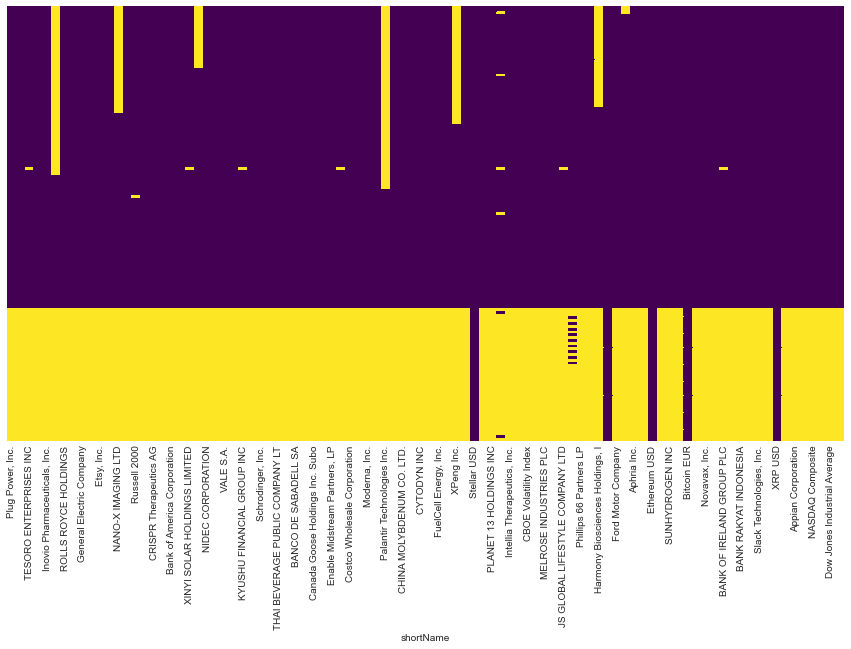

In [62]:
fig, ax = plt.subplots(figsize=(15,8))
sns_heatmap = sns.heatmap(full_ticker_df.isnull(), 
                          yticklabels=False, 
                          cbar=False, 
                          cmap='viridis')

Бесплатная версия API отдаёт не все актуальные данные. Для простоты выбросим все пропуски из конца рядов и удалим ряды с большим числом пропусков в начале.

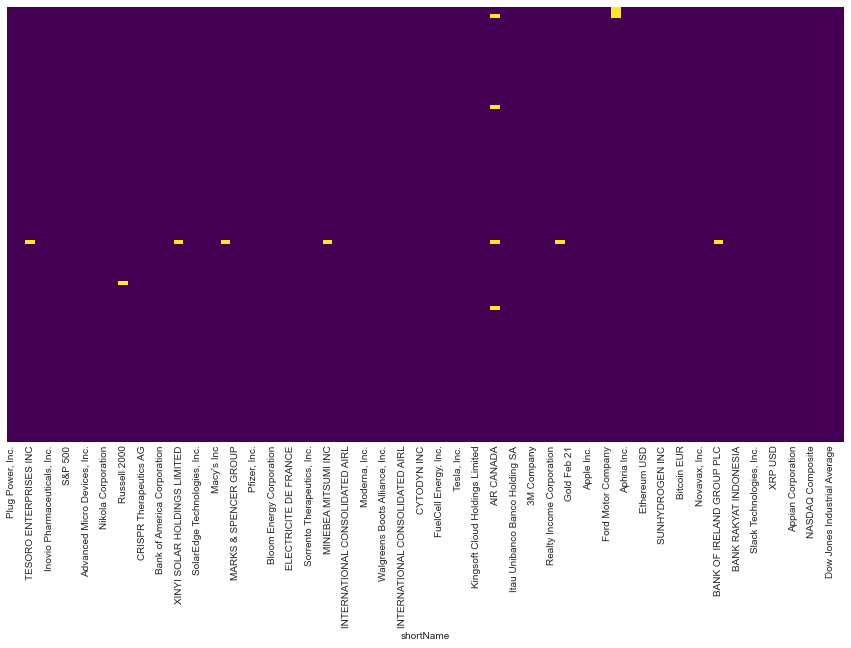

In [90]:
ticker_df = full_ticker_df[:-48]

papers = ticker_df.isnull().mean() 
nice_papers = papers[papers < 0.2].index

ticker_df = ticker_df[nice_papers]

fig, ax = plt.subplots(figsize=(15,8))
sns_heatmap = sns.heatmap(ticker_df.isnull(), 
                          yticklabels=False, 
                          cbar=False, 
                          cmap='viridis')

Оставшиеся пропуски заполним средними значениямм. На кластеризацию это существенным образом повлиять не должно. 

In [93]:
for item in ticker_df.columns:
    mn = ticker_df[item].mean()
    ticker_df[item] = ticker_df[item].fillna(mn)

## Зачем кластеризовать акции? 

Обычно инвесторы хотят диверсифицировать риск и стабильно зарабатывать. Если у нас в портфеле есть две акции, которые ведут себя одинаково - при падении одной, будет падать и вторая. Мы потеряем много денег. Если бы динамика второй акции была бы другой, то мы были бы лучше застрахованы от кризисной ситуации.  Получается, что для стабильности портфеля, логично покупать акции из разных кластеров, а не из одного и того же.

Нарисуем несколько рядов из нашего набора данных. 

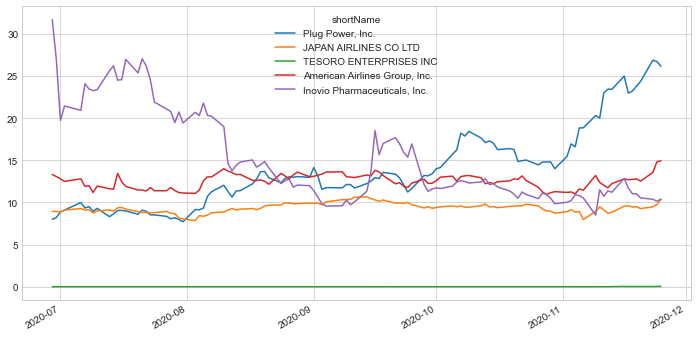

In [100]:
ticker_df.iloc[:,:5].plot(figsize=(12,6));

Видим, что акции колеблются в разных ценовых диапазонах. Отмасштабируем их стоимость, чтобы разные цены никак не влияли на расчёт метрик расстояния. Для нас важна именно динамика, а не абсолютная стоимость бумаги. 

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(ticker_df)

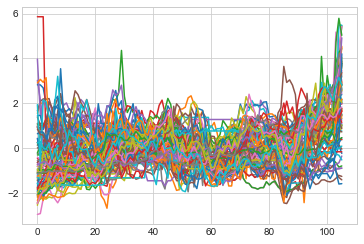

In [107]:
plt.plot(tickers_scaled);

# 3. K-means

Будем считать поокоординатное Евклидово расстояние между нашими рядами и на основе этого кластеризовать их. Для этого нам понадобится [библиотека `tslearn`,](https://github.com/tslearn-team/tslearn) в рамках которой реализовано несколько разных методов кластеризации.

```
pip3 install tslearn
```

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

In [ ]:
distortions = []
silhouette = []

K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [ ]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(tickers_scaled)

In [ ]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [ ]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

In [ ]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# 4. DTW 

Сделаем всё то же самое, но теперь в качестве метрики будем использовать DTW. 

In [ ]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [ ]:
n_clusters = 4
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(tickers_scaled)

In [ ]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [ ]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

In [ ]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# Материалы:

- Реализация DTW своими руками: https://nbviewer.jupyter.org/github/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb